# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [59]:
import copy
import random
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!pip install tabulate
from tabulate import tabulate

from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'retina'

In [60]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [61]:
def generate_synthetic(size: int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

In [62]:
# for weights path
def plot_weights(X, y, model, penalty_range, names=None, intercept=True):
    weight_path = np.zeros((X.shape[1] + 1, penalty_range.shape[0]))

    for i, penalty in enumerate(penalty_range):
        model.lambda_ = penalty
            
        model.fit(X, y)
        weight_path[:, i] = model._w.ravel()

    if not intercept:
        weight_path = weight_path[:-1]
        
    plt.figure(figsize=(10, 6))
    for i, w in enumerate(weight_path):
        plt.plot(penalty_range, w, label=names[i] if names else str(i))
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.xlabel("$\lambda$")
    plt.ylabel("$W_{i}$")
    plt.grid()

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [5]:
def mse(y_true: np.ndarray, y_pred: np.ndarray):    
    return np.sum((y_true - y_pred)**2) / y_true.shape[0]

def r2(y_true: np.ndarray, y_pred: np.ndarray):
    y_mean = np.mean(y_true)
    denominator = np.sum((y_true - y_mean)**2)
    numerator = np.sum((y_true - y_pred)**2)
    
    return 1 - numerator / denominator

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [6]:
class NormalLR:
    def __init__(self, normalize=False, lambda_=0.0):
        self.normalize = normalize
        self.lambda_ = lambda_
        
        self._w = None
        
    def _add_intercept(self, X: np.ndarray) -> np.ndarray:        
        return np.hstack([X, np.ones((X.shape[0], 1))])
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'NormalLR':
        if self.normalize:
            self._mean, self._std = X.mean(axis=0), X.std(axis=0)
            X = (X - self._mean) / self._std
        X = self._add_intercept(X)

        X_inverse = np.linalg.inv(X.T @ X + self.lambda_ * np.identity(X.shape[1]))
        self._w = X_inverse @ X.T @ y
        
        return self
            
    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.normalize:
            X = (X - self._mean) / self._std
        X = self._add_intercept(X)
              
        return (X @ self._w.reshape(-1, 1)).ravel()
    
    def __repr__(self):
        params = [item for item in self.__dict__.items() if not item[0].startswith("_")]
        params_str = [f'{item[0]}={item[1]}' for item in params]
        
        return f"{self.__class__.__name__}({', '.join(params_str)})"

In [7]:
er_mse, er_r2 = [], []
for _ in range(100):
    X, y = generate_synthetic(1024)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    
    y_pred = NormalLR().fit(X_train, y_train).predict(X_test)
    er_mse.append(mse(y_test, y_pred))
    er_r2.append(r2(y_test, y_pred))
    
print(f"MSE: {np.mean(er_mse)} ± {np.std(er_mse)},\nR2: {np.mean(er_r2)} ± {np.std(er_r2)}")

MSE: 0.009910378572834123 ± 0.0009928169294155847,
R2: 0.9974916814860556 ± 0.0019190422069776283


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [8]:
class GradientLasso:
    def __init__(self, alpha: float, normalize=False, tol=1e-8, iterations=10000, lambda_=0.0):
        self.alpha = alpha
        self.normalize = normalize
        
        self.lambda_ = lambda_
        self.tol = tol
        self.max_iter = iterations
        
    def _grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        return (2 / y.shape[0]) * X.T @ (X @ w - y) + self.lambda_ * np.sign(w)
        
    def _add_intercept(self, X: np.ndarray) -> np.ndarray:        
        return np.hstack([X, np.ones((X.shape[0], 1))])    
    
    def _prep_data(self, X, fit=True):
        if self.normalize:
            if fit:
                self._mean, self._std = X.mean(axis=0), X.std(axis=0)
            X = (X - self._mean) / self._std
            
        return self._add_intercept(X)
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'GradientLasso':
        X, y = self._prep_data(X), y.reshape(-1, 1)

        self._w = np.zeros((X.shape[1], 1))
        
        for _ in range(self.max_iter):
            direction = self._grad(X, y, self._w)
            self._w = self._w - self.alpha * direction 

            if direction.T @ direction <= self.tol:
                break
        
        return self
        
    def predict(self, X: np.ndarray):
        X = self._prep_data(X, fit=False)
        
        return (X @ self._w).ravel()
    
    def __repr__(self):
        params = [item for item in test_model.__dict__.items() if not item[0].startswith("_")]
        params_str = [f'{item[0]}={item[1]}' for item in params]
        
        return f"{self.__class__.__name__}({', '.join(params_str)})"

In [9]:
X, y = generate_synthetic(512)

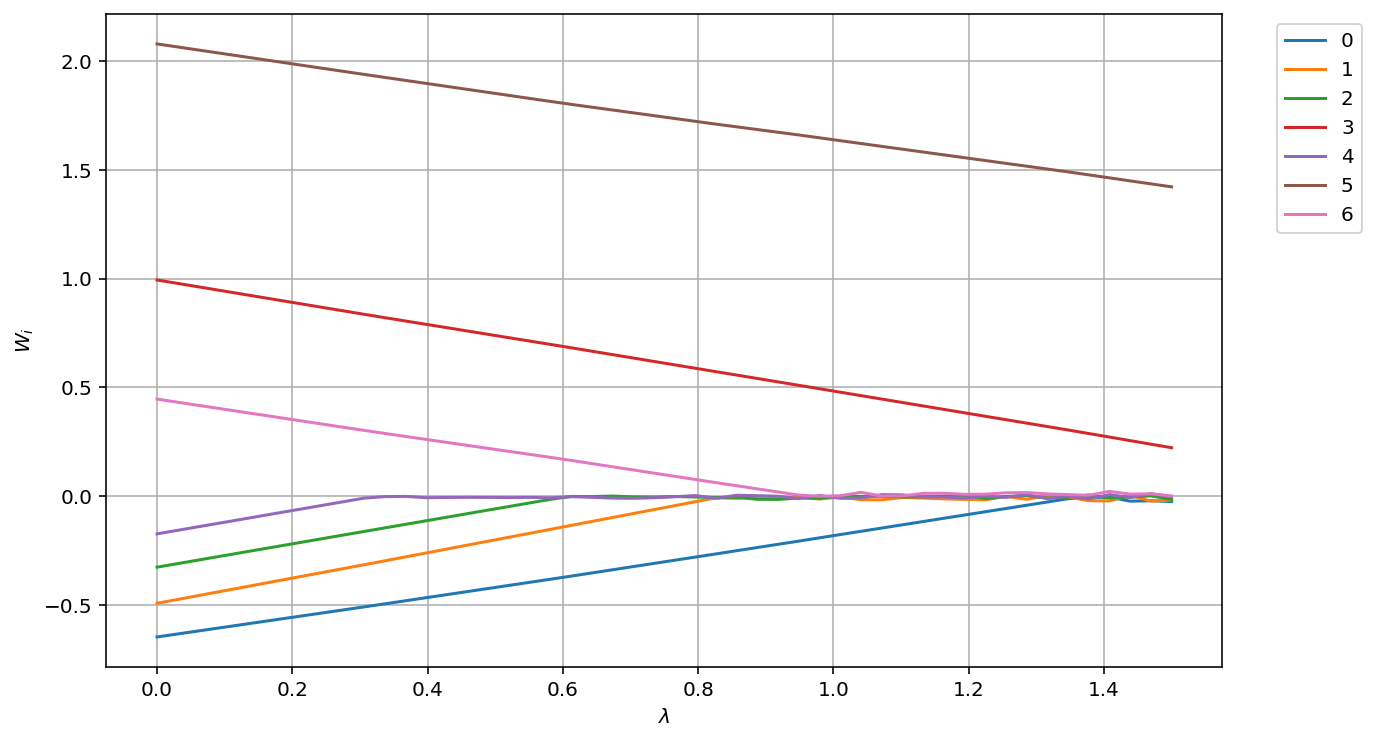

In [10]:
plot_weights(X, y, GradientLasso(alpha=0.01), np.linspace(0, 1.5, 50))

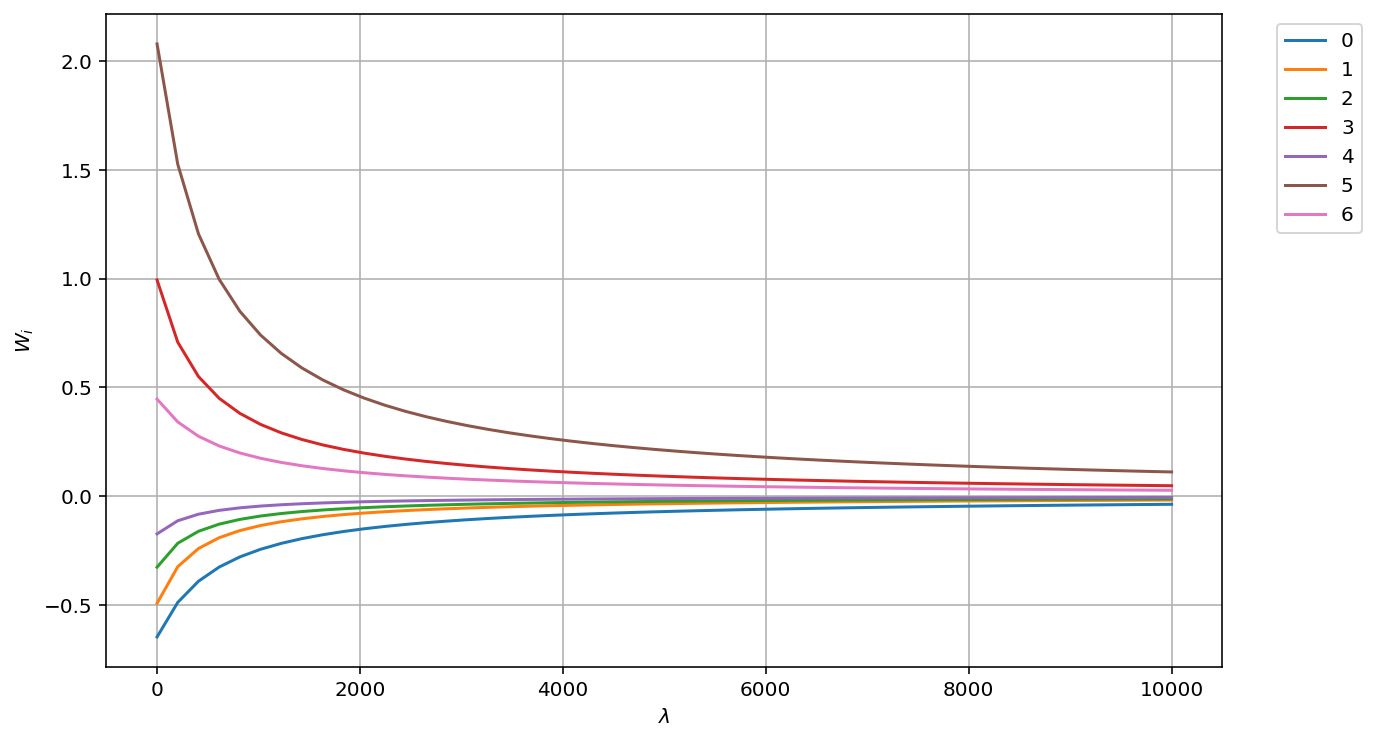

In [11]:
plot_weights(X, y, NormalLR(), np.linspace(0, 10000, 50))

In [12]:
def build_plot(X_train, y_train, X_test, y_test, l_range=None):
    if l_range is None:
        l_range = (0.0, 0.002, 0.00002)

    xs = np.arange(*l_range)
    errors = []
    for x in xs:
        regr = GradientLasso(alpha=0.1, normalize=True, iterations=10000, lambda_=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.xlabel("$\lambda$")
    plt.ylabel("MSE")
    plt.show()

In [13]:
er_mse, er_r2 = [], []
for _ in range(100):
    X, y = generate_synthetic(1024)
    X, X_val,y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)
    
    y_pred = GradientLasso(0.1, iterations=10000).fit(X_train, y_train).predict(X_test)
    er_mse.append(mse(y_test, y_pred))
    er_r2.append(r2(y_test, y_pred))
    
print(f"MSE: {np.mean(er_mse)} ± {np.std(er_mse)},\nR2: {np.mean(er_r2)} ± {np.std(er_r2)}")

MSE: 0.009946368675244031 ± 0.0009670268085358628,
R2: 0.9976959739052318 ± 0.0016515659458398052


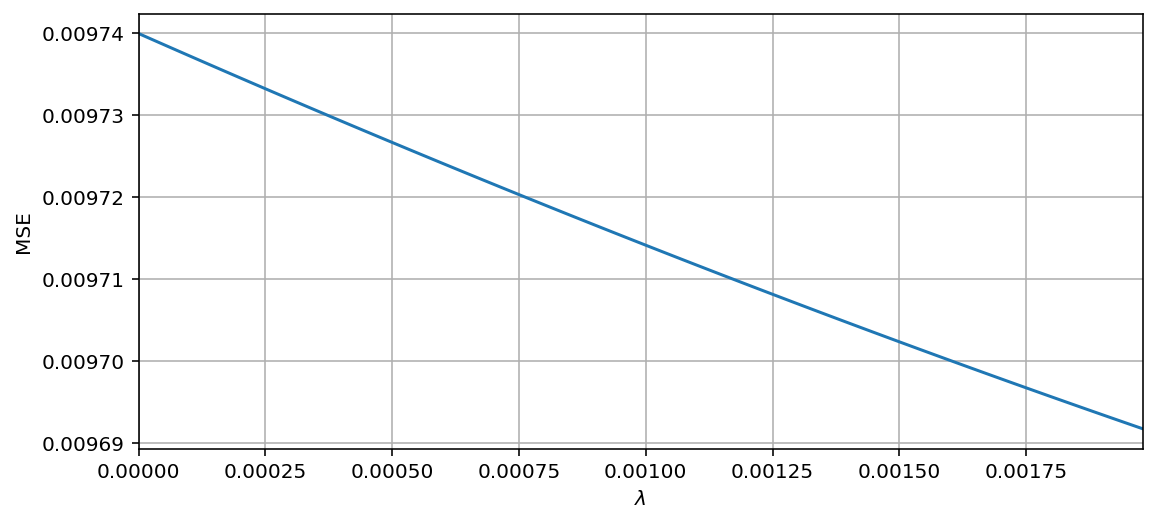

In [14]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

build_plot(X_train, y_train, X_val, y_val)

### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [15]:
features = ["crim", "zn", "indus", 
            "chas", "nox", "rm",
            "age", "dis", "rad", 
            "tax", "ptratio", "b", "lstat"]

In [16]:
X, y = read_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

In [17]:
model_ols = NormalLR(normalize=True)
model_ols.fit(X_train, y_train)
y_pred = model_ols.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 22266311.080836907, R2: 0.687279747566105


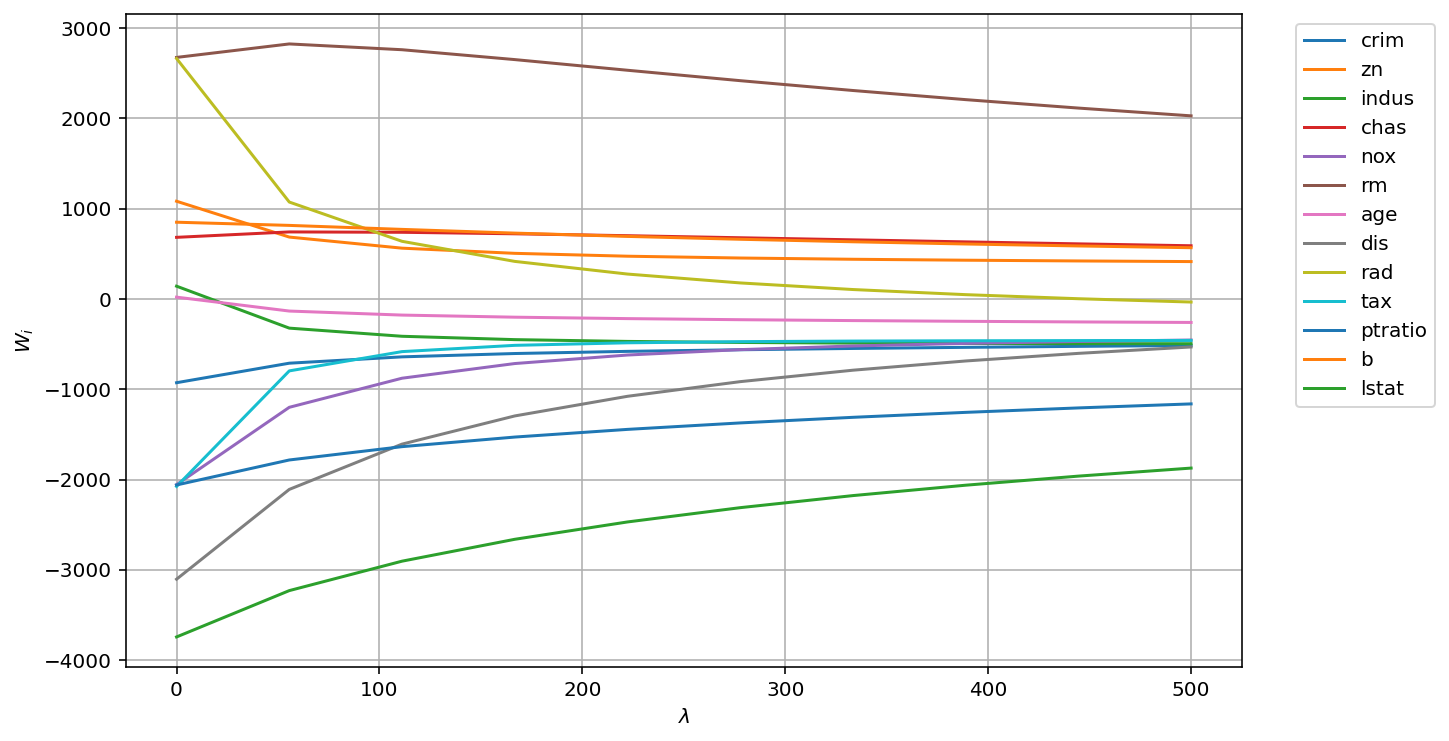

In [18]:
plot_weights(X, y, NormalLR(normalize=True), np.linspace(0, 500, 10), names=features, intercept=False)

In [19]:
model_lasso = GradientLasso(0.1, normalize=True, iterations=10000, lambda_=230.0)
model_lasso.fit(X_train, y_train)
y_pred = model_lasso.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 21699250.6402414, R2: 0.695243854574424


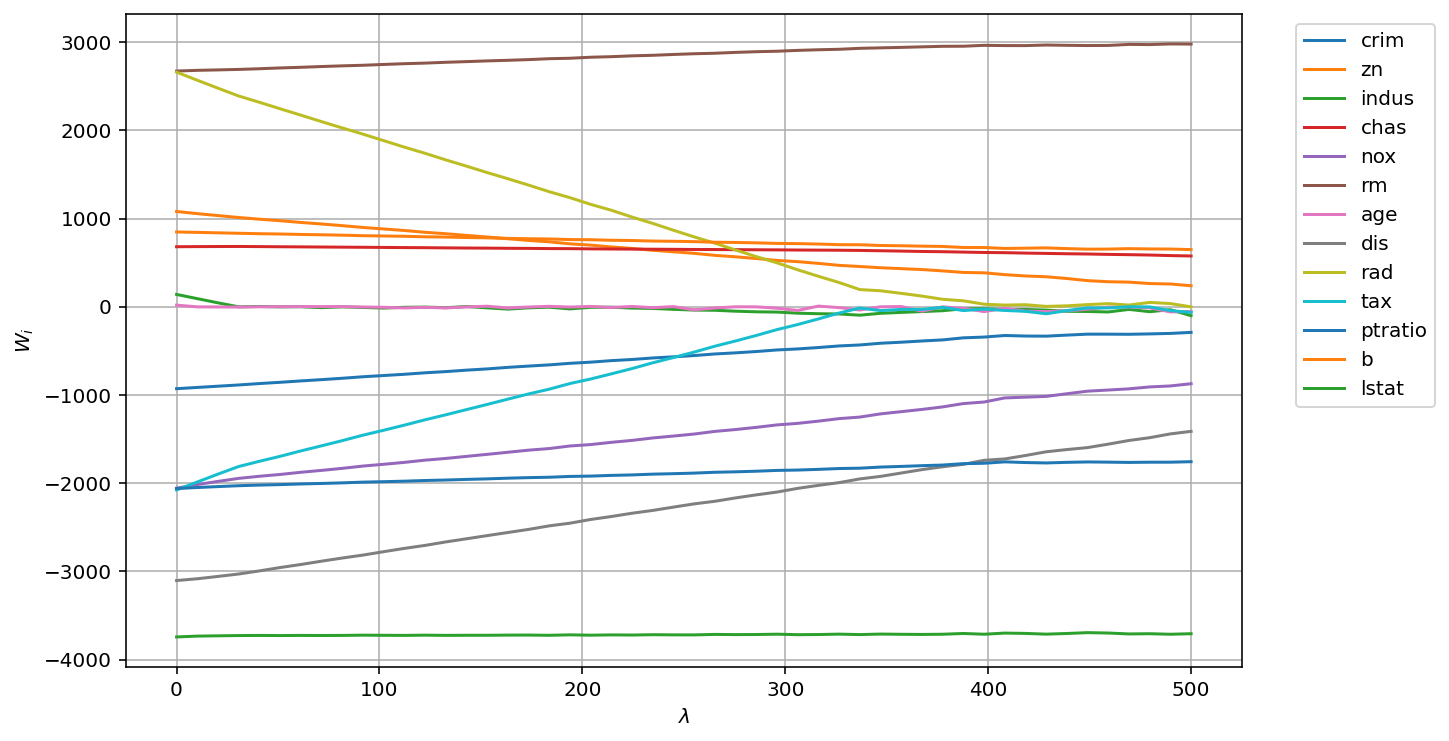

In [20]:
plot_weights(X, y, GradientLasso(normalize=True, alpha=0.1),
             np.linspace(0, 500, 50), names=features, intercept=False)

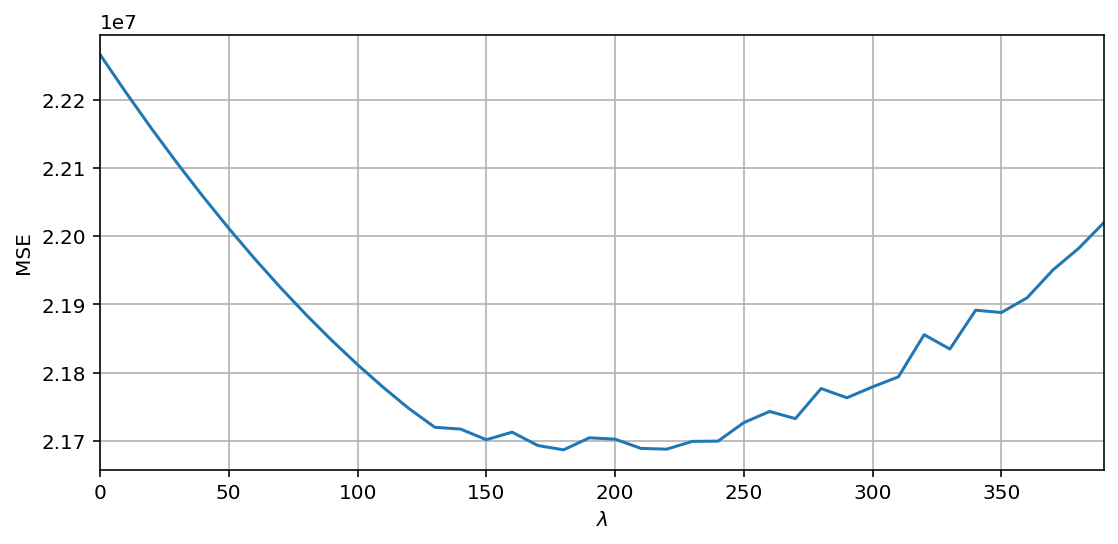

In [21]:
build_plot(X_train, y_train, X_test, y_test, (0.0, 400, 10.0))

### Задание 5 (2 балла)
Проинтерпретируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

In [22]:
!head -n 14 boston.csv

#  1. crim     per capita crime rate by town
#  2. zn       proportion of residential land zoned for lots over 25,000 sq.ft.
#  3. indus    proportion of non-retail business acres per town
#  4. chas     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
#  5. nox      nitric oxides concentration (parts per 10 million)
#  6. rm       average number of rooms per dwelling
#  7. age      proportion of owner-occupied units built prior to 1940
#  8. dis      weighted distances to five Boston employment centres
#  9. rad      index of accessibility to radial highways
# 10. tax      full-value property-tax rate per $10,000
# 11. ptratio  pupil-teacher ratio by town
# 12. b        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
# 13. lstat    % lower status of the population
# 14. medv     median value of owner-occupied homes in $'s


In [38]:
def feature_weights(model):
    features = ["crim", "zn", "indus", "chas", 
                "nox", "rm", "age", "dis", "rad",
                "tax", "ptratio", "b", "lstat"]

    table = sorted(zip(features, model._w), key=lambda t: -abs(t[1]))
    print(tabulate([("Feature", "Weight")] + table, headers="firstrow", tablefmt="github"))
    
    
def feature_importance(X, y, model):
    ref_score = r2(y, model.predict(X))
    feature_scores = []
    features = ["crim", "zn", "indus", "chas", 
                "nox", "rm", "age", "dis", "rad",
                "tax", "ptratio", "b", "lstat"]
    
    for feature in range(X.shape[1]):
        scores = np.zeros(100)
        for i in range(100):
            X_new = X.copy()
            np.random.shuffle(X_new[:, feature], )
            scores[i] = r2(y, model.predict(X_new))
            
        feature_scores.append([features[feature], ref_score - np.mean(scores), np.std(scores)])
    
    table = [["Feature", "Importance", "Std"]] + sorted(feature_scores, key=lambda t: -t[1])
        
    print(tabulate(table, headers="firstrow", tablefmt="github"))
    

def train_model(model, drop_features=None, verbose=False):
    X, y = read_data()
    if drop_features:
        X = np.delete(X, drop_features, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if verbose:
        print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")
    return mse(y_test, y_pred)
    
    
def simple_feature_selector(model, n_features):
    min_mse = np.inf
    
    best_drop = []
    while True:
        best_one = None
        for feature in range(n_features):
            err = train_model(model, best_drop + [feature])
            if err < min_mse:
                min_mse = err
                best_one = feature
        
        if best_one is None:
            break
        best_drop.append(best_one)
        
    return best_drop

Есть несколько способов посмотреть на то, как признаки влияют на предсказания модели. Говорить о значимости по весам будет неверным, даже если мы прежде нормировали данные. Тем не менее, можно сказать о направлении связи, а также об отношении относительно среднего (т.к. данные нормированы). По весам обученной Lasso модели можно сказать, что наибольшая положительная связь с медианной ценой домой в районе у переменной **rm**, а наибольшая отрицательная у **lstat**. Выглядит вполне разумным: чем больше в среднем комнат в доме, тем больше дом и тем выше будет медиання цена. Чем больше процент населения с низким статусом (чтобы это не значило), тем меньше будет медианная цена (если до туда еще не дошла джентрификация). Следующей положительно связанной переменной является **rad**, чем ближе метро к району/дому тем больше он стоит. Следующие переменные с отрицательной связью: **rad** и **ptratio** - чем меньше учителей (и вероятно школ) и дальше расстояние до центров трудоустройства, тем ниже медианная цена. Можно было бы говорить, о том насколько увеличивается/уменьшается цена относительно среднего при изменении признаков на какое-то значение, но без p-value будет далеко от правды.

In [42]:
feature_weights(model_lasso)

| Feature   |       Weight |
|-----------|--------------|
| lstat     | -3909.43     |
| rm        |  2808.92     |
| dis       | -2588.73     |
| ptratio   | -1803.96     |
| nox       | -1437.22     |
| rad       |  1195.01     |
| tax       | -1016.67     |
| zn        |   793.672    |
| b         |   698.237    |
| crim      |  -621.277    |
| chas      |   556.586    |
| indus     |  -281.644    |
| age       |    -0.300191 |


Можно сделать простую проверку важности признаков с помощью permutation importance, простого показателя - надо перемешать какой-то признак и посмотреть насколько сильно сломается модель. Чем сильнее упала метрика предсказания, тем важнее признак. В целом, ранжирование по такому признаку совпадает с весами. Интересно, что переменная **crime** почти не связана с медианной ценой.

In [24]:
feature_importance(X_test, y_test, model_lasso)

| Feature   |   Importance |         Std |
|-----------|--------------|-------------|
| lstat     |  0.2962      | 0.0545134   |
| dis       |  0.174691    | 0.0335108   |
| rm        |  0.159193    | 0.0347269   |
| ptratio   |  0.102532    | 0.0229856   |
| rad       |  0.0559813   | 0.016121    |
| nox       |  0.0401756   | 0.0175954   |
| chas      |  0.0179405   | 0.0080133   |
| b         |  0.0123574   | 0.00879592  |
| tax       |  0.00984374  | 0.0124147   |
| zn        |  0.00748588  | 0.00745717  |
| crim      |  0.00453141  | 0.00486764  |
| age       |  7.82109e-07 | 4.15568e-06 |
| indus     | -0.00455132  | 0.00332938  |


Можно также дополнительно посмотреть на коэффициент корреляции между признаками и медианной ценой. Опять же, ранжирование получается очень похожим. 

In [52]:
df = pd.DataFrame(np.hstack([X, y.reshape(-1, 1)]), 
                  columns=["crim", "zn", "indus", "chas", 
                           "nox", "rm", "age", "dis", "rad",
                           "tax", "ptratio", "b", "lstat", "medv"])

df.drop("medv", axis=1).corrwith(df["medv"]).sort_values()

lstat     -0.737663
ptratio   -0.507787
indus     -0.483725
tax       -0.468536
nox       -0.427321
crim      -0.388305
rad       -0.381626
age       -0.376955
chas       0.175260
dis        0.249929
b          0.333461
zn         0.360445
rm         0.695360
dtype: float64

In [53]:
df.corr()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
crim,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
zn,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
indus,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
chas,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
nox,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
rm,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
age,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
dis,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
rad,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
tax,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


Тем не менее, в данных есть переменные которые сильно связаны. Если их убрать можно чуть чуть улучшить качество. С помощью простого жадного перебора можно их найти. Это признаки **indus**, **tax**, **rm**. Последние два признака имеют большую корреляцию с таргетом, однако также сильно связаны с lstat и rad.

In [54]:
simple_feature_selector(NormalLR(normalize=True, lambda_=8.5), 13)

[2, 9, 6]

In [55]:
train_model(GradientLasso(normalize=True, alpha=0.01, lambda_=230), [2, 6, 9], verbose=True);

MSE: 21300450.46911544, R2: 0.70084482232038


In [56]:
train_model(NormalLR(normalize=True, lambda_=8.5), [2, 6, 9], verbose=True);

MSE: 20843678.309990782, R2: 0.7072599803763173
